# U.S. Medical Insurance Costs

Note, for this work $\alpha = 0.05$ will be used.

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from scipy import stats
import seaborn as sns

In [2]:
df = pd.read_csv("insurance.csv")

In [3]:
display(df.head())

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## INITIAL EDA

In [4]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


No nulls.
Lets check for incorrectly entered data.

In [60]:
print('Number of entries with 0 bmi: {}'.format(df[df['bmi'] == 0].shape[0]))
print('Number of entries with age < 18: {}'.format(df[df['age'] < 18].shape[0]))
print('Number of entries with 0 charges: {}'.format(df[df['charges'] == 0].shape[0]))


Number of entries with 0 bmi: 0
Number of entries with age < 18: 0
Number of entries with 0 charges: 0


Every entry in our data set has a valid bmi, age and charge. We will consider the data clean.

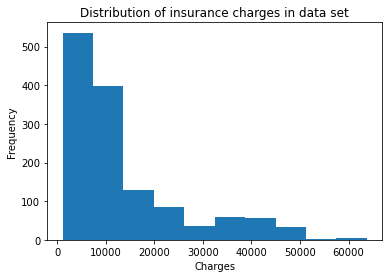

In [5]:
plt.hist(df['charges'])
plt.xlabel('Charges')
plt.ylabel('Frequency')
plt.title('Distribution of insurance charges in data set')
plt.show()

Non-normal distributution, but we have a large number data points. Will have an impact of statistical tests

In [6]:
display(df['sex'].value_counts())

male      676
female    662
Name: sex, dtype: int64

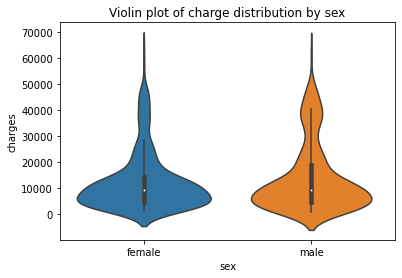

In [7]:
sns.violinplot(x = 'sex',y='charges', data = df)
plt.title('Violin plot of charge distribution by sex')
plt.show()

In [8]:
df['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

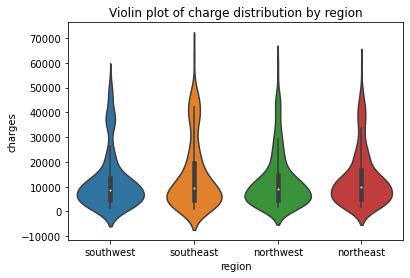

In [9]:
sns.violinplot(x='region', y = 'charges', data = df)
plt.title('Violin plot of charge distribution by region')
plt.show()

Fairly equal representations of both sexes and all four regions. Neither seem to have important relationships with the insurance charges.

In [10]:
df['children'].value_counts()

0    574
1    324
2    240
3    157
4     25
5     18
Name: children, dtype: int64

,children,age,bmi,charges
0,0,38.444251,30.550296,12365.975602
1,1,39.453704,30.623148,12731.171832
2,2,39.445833,30.978104,15073.563734
3,3,41.566879,30.684331,15355.318367
4,4,39.000000,31.391200,13850.656311
5,5,35.611111,29.605000,8786.035247


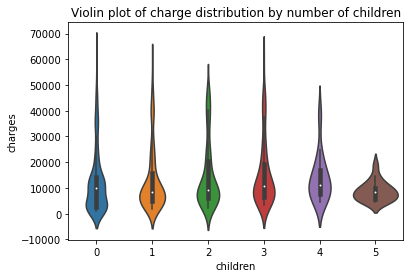

In [11]:
child_df = df.groupby('children', as_index = False).mean()
display(child_df)
sns.violinplot(x='children', y = 'charges', data = df)
plt.title('Violin plot of charge distribution by number of children')
plt.show()

More people in dataset with less children. Have the acknowledge that 4 and 5 children people are under represented in this data set. People with 2 or 3 children seem to pay more than the rest, will investigate further.

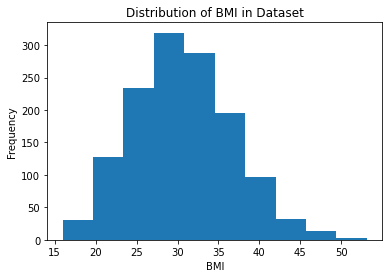

In [12]:
plt.hist(df['bmi'])
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.title('Distribution of BMI in Dataset')
plt.show()

Normally distributed BMI. Peak at around 30, the threshold for obesity. Close to real US distribution (https://www.niddk.nih.gov/health-information/health-statistics/overweight-obesity).

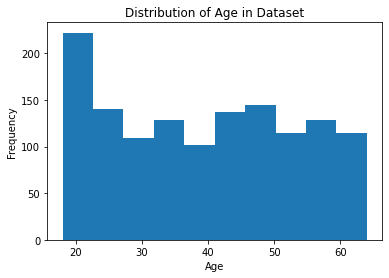

In [13]:
plt.hist(df['age'])
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Age in Dataset')
plt.show()

More young people (~20 years old) in the data set than other category. This is not representative of the general population of America, which has peaks in the 25-29 and 55-59 brackets (https://www.statista.com/statistics/241488/population-of-the-us-by-sex-and-age/). Might need to account for this bias.

In [14]:
num_df_corr = df.corr()
print('Correlation of numerical variable with insurance charge')
display(num_df_corr['charges'])

Correlation of numerical variable with insurance charge


age         0.299008
bmi         0.198341
children    0.067998
charges     1.000000
Name: charges, dtype: float64

Age and bmi correlate positively with charges, so these should be investigated further. This suggests that number of children has no impact, but we say previously that it was not a linear relationship (e.g. people with 2 or 3 children payed more than those with none or 5).

In [15]:
df['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

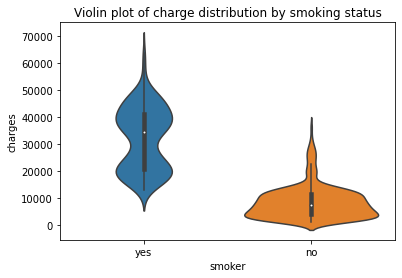

In [16]:
sns.violinplot(x='smoker', y = 'charges', data = df)
plt.title('Violin plot of charge distribution by smoking status')
plt.show()

Smoking appears to greatly increase the cost of insurance, investigate this further as well. However should note that smokers are over represented in this data set, the set is roughly 20% smokers, whereas the national rate in the US is 12.5% (https://www.cdc.gov/tobacco/data_statistics/fact_sheets/adult_data/cig_smoking/index.htm).

### Initial findings

Representation in the set:
 - gender and location are equally represented
 - bmi distribution reflect US population
 - young people and smokers are over-represented

Impact on insurance charges
 - bmi 
 - smoking status 
 - age 
 - number of children


We will now investigate the factors affecting insurance charges in more detail.

## SMOKING DEPENDANCE

First lets look at the impact of smoking on the cost of insurance.

In [17]:
smoke_df  = df.groupby('smoker').mean()
mean_charge_smoker = smoke_df['charges'][1]
mean_charge_nonsmoker = smoke_df['charges'][0]
diff_smoker = mean_charge_smoker - mean_charge_nonsmoker
sd = df['charges'].std()
num_sd_smoker_diff = diff_smoker/sd
print('Average insurance cost for smoker: ${:.2f}'.format(mean_charge_smoker))
print('Average insurance cost for non-smoker: ${:.2f}'.format(mean_charge_nonsmoker))
print('Number of standard deviations of charge increase if smoker: {}'.format(num_sd_smoker_diff))
print('Percentage increase in charge if smoker: {:.2f} %'.format(mean_charge_smoker/mean_charge_nonsmoker*100-100))

Average insurance cost for smoker: $32050.23
Average insurance cost for non-smoker: $8434.27
Number of standard deviations of charge increase if smoker: 1.950119043830363
Percentage increase in charge if smoker: 280.00 %


Clearly a large increase in cost for smokers. Lets check the distributions before we do any statistical testing. 

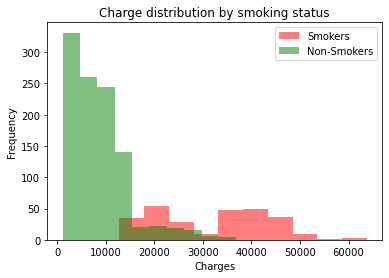

In [18]:
smoker_charges = df[ df['smoker'] == 'yes']['charges'].to_numpy()
nonsmoker_charges = df[ df['smoker'] == 'no']['charges'].to_numpy()
plt.hist(smoker_charges,color ='red', alpha = 0.5, label = 'Smokers')
plt.hist(nonsmoker_charges,color ='green', alpha = 0.5, label = 'Non-Smokers')
plt.xlabel('Charges')
plt.ylabel('Frequency')
plt.title('Charge distribution by smoking status')
plt.legend()
plt.show()

The two populations are not normally distributed, and have unequal sizes. This suggests a non-parametrized test for significance for the difference of the two population means. However as we have a decently sized sample, we can try a ttest as well. First lets compare the variance of the two populations.

In [19]:
smoker_charges = df[ df['smoker'] == 'yes']['charges'].to_numpy()
nonsmoker_charges = df[ df['smoker'] == 'no']['charges'].to_numpy()
print('Smoker charge variance: {}\nNon smoker charge variance: {}'.format(smoker_charges.std(),nonsmoker_charges.std()) )

Smoker charge variance: 11520.46670652943
Non smoker charge variance: 5990.9645302876115


Unequal variance, so will use Welch's t-test to start, robust to difference variance and population sizes. The null hypothesis is that the two means are equal, and the alternate is that the charges for smokers are larger.

In [20]:
stats.ttest_ind(smoker_charges,nonsmoker_charges, alternative = 'greater', equal_var = False)

Ttest_indResult(statistic=32.751887766341824, pvalue=2.94473222335849e-103)

Suggests the increase in insurance charges for smokers is significant ($p = 10^{-103}$). Lets back up this result with non-parametric test, Mann-Whitney U. The null hypothesis is that the underlying distributions are the same, with for example the same location.

In [21]:
stats.mannwhitneyu(smoker_charges,nonsmoker_charges, alternative = 'greater') 

MannwhitneyuResult(statistic=284133.0, pvalue=2.6351167222517853e-130)

This result ($p = 10^{-130}$) confirms that we can reject the null hypothesis and that the increase in insurance charges for smokers is statistically significant.

### Smokers findings
There is a 280% increase in insurance charges for people who smoke. This increase is significant as per testing above.

## AGE DEPENDANCE


We previously found a positive correlation between age and charges. Lets first plot charges as a function of age to try understand this relationship better.

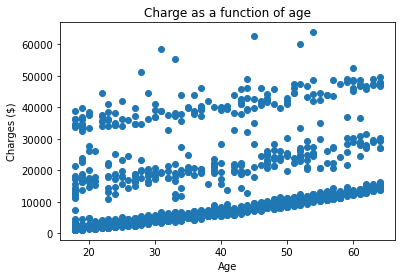

In [22]:
age_vector = df['age'].to_numpy()
charge_vector = df['charges'].to_numpy()
plt.scatter(age_vector, charge_vector)
plt.xlabel('Age')
plt.ylabel('Charges ($)')
plt.title('Charge as a function of age')
plt.show()

There is a clear increase with age, with the minimum insurance charge increasing monotonically with age. However there are two rough tiers of higher charges, we will try to determine the causes of these.

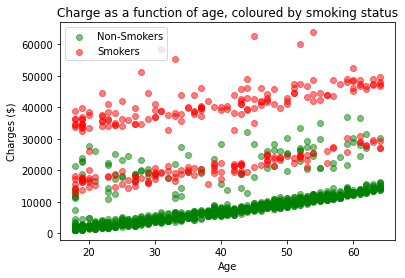

In [26]:
smoking_boolean = df['smoker'] == 'yes'
nonsmoking_boolean = df['smoker'] == 'no'
plt.scatter(age_vector[nonsmoking_boolean], charge_vector[nonsmoking_boolean], c= 'green', label='Non-Smokers', alpha = 0.5)
plt.scatter(age_vector[smoking_boolean], charge_vector[smoking_boolean], c= 'red', label='Smokers', alpha = 0.5)
plt.xlabel('Age')
plt.ylabel('Charges ($)')
plt.legend()
plt.title('Charge as a function of age, coloured by smoking status')
plt.show()

Clearly shown that age increases the charges in general, and that smoking status can account for some of the higher tiers, however there must be other factors at play.

## BMI

Maybe this is another factor for increased charges, as it was found to positively correlate with charges in our EDA.

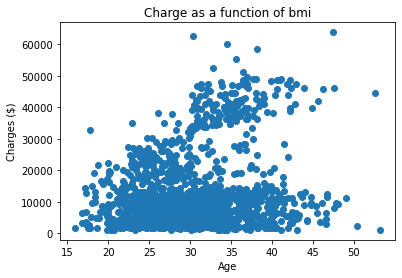

In [24]:
bmis = df['bmi']
plt.scatter(bmis, charge_vector)
plt.xlabel('Age')
plt.ylabel('Charges ($)')
plt.title('Charge as a function of bmi')
plt.show()

Does not seem to be a strong relationship between bmi and charges, as many high bmi people pay the same. However, there does appear to be a threshold at around 30, the bmi for obesity. So lets quickly look at this.

First we will add some tiering to the BMI, using the standard thresholds from the CDC:
- $<18.5$ underweight
- $18.5 - <25$ healthy
- $25- <30$ overweight
- $>30$ obese

In [34]:
# Helper function to assign a bmi tier based on bmi
def bmi(bmi:int) -> str:
    if bmi < 18.5: return 'Underweight'
    elif bmi < 25: return 'Healthy'
    elif bmi < 30: return 'Overweight'
    else: return 'Obese'

#Assign BMI tiering to new column.
df['BMI_Tier'] = df['bmi'].apply(bmi)
display(df.head())

,age,sex,bmi,children,smoker,region,charges,BMI_Tier
0,19,female,27.900,0,yes,southwest,16884.92400,Overweight
1,18,male,33.770,1,no,southeast,1725.55230,Obese
2,28,male,33.000,3,no,southeast,4449.46200,Obese
3,33,male,22.705,0,no,northwest,21984.47061,Healthy
4,32,male,28.880,0,no,northwest,3866.85520,Overweight


Now we can analyse the effect of BMI tier on insurance charges.

In [61]:
bmi_df = df.groupby('BMI_Tier', as_index = False).mean()
display(bmi_df)
display(df['BMI_Tier'].value_counts())
print('Increase in charges due to obesity compared to healthy: {:.2f} %'.format(bmi_df['charges'][1]/bmi_df['charges'][0]*100-100))

,BMI_Tier,age,bmi,children,charges
0,Healthy,36.733333,22.616133,1.128889,10409.337709
1,Obese,40.343706,35.266011,1.106082,15552.335469
2,Overweight,38.922280,27.602591,1.056995,10987.509891
3,Underweight,32.350000,17.566250,1.050000,8852.200585


Obese          707
Overweight     386
Healthy        225
Underweight     20
Name: BMI_Tier, dtype: int64

Increase in charges due to obesity compared to healthy: 49.41 %


A clear increase in charges for obese people and a decrease for underweight people, compared to healthy and overweight people. Lets check if the increase for obese people is significant. As with the US population, obese people account for half the data set. First we again check the distributions.

In [43]:
obese_boolean = df['BMI_Tier'] == 'Obese'
nonobese_boolean = df['BMI_Tier'] != 'Obese'

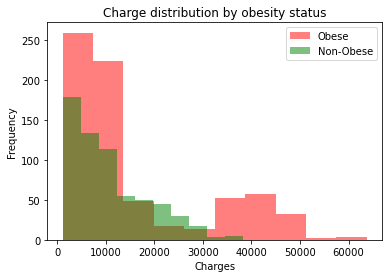

In [46]:
obese_charges = charge_vector[obese_boolean]
nonobese_charges = charge_vector[nonobese_boolean]
plt.hist(obese_charges,color ='red', alpha = 0.5, label = 'Obese')
plt.hist(nonobese_charges,color ='green', alpha = 0.5, label = 'Non-Obese')
plt.xlabel('Charges')
plt.ylabel('Frequency')
plt.title('Charge distribution by obesity status')
plt.legend()
plt.show()

Once again we have non-normal distributions, with unequal sample sizes and unequal variances (by inspection), so lets again use our two statistical tests to determine the significance of the change in charges due to being obese. These are again one sided tests with the null being the means are the same, and the alternate hypothesis that the obesity charges have a higher mean.

In [63]:
# Welch's t-test
stats.ttest_ind(obese_charges,nonobese_charges, alternative = 'greater', equal_var = False)

Ttest_indResult(statistic=7.679158554353561, pvalue=1.7520024527809808e-14)

In [64]:
# Mann-Whitney U
stats.mannwhitneyu(obese_charges,nonobese_charges, alternative = 'greater') 

MannwhitneyuResult(statistic=250364.0, pvalue=5.440342798784988e-05)

Both these results suggest the increase in insurance charges with obesity is significant, with $ p = 10^{-14}$ for Welch's and $p = 10^{-5}$ for Mann Whitney. So we can reject the null hypothesis.

However we must note that the distribution above suggests that obesity does not always preclude higher charges, as there are a large number of obese people paying close to the minimum.

So obesity is another factor causing increase in charges (significant increase). Does this explain the other gradations in the age vs charge plot?

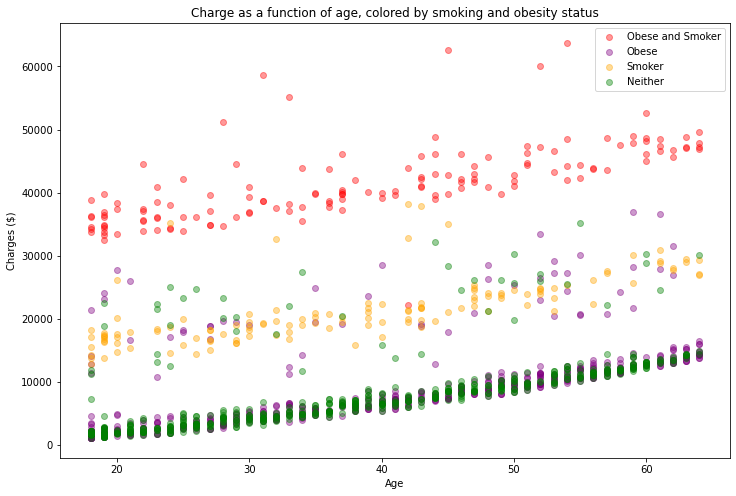

In [75]:
smoker_obese_boolean = obese_boolean & smoking_boolean
nonsmoker_obese_boolean = obese_boolean & nonsmoking_boolean
smoker_nonobese_boolean = nonobese_boolean & smoking_boolean
nonsmoker_nonobese_boolean = nonobese_boolean & nonsmoking_boolean
plt.rcParams['figure.figsize'] = [12, 8]
plt.scatter(age_vector[smoker_obese_boolean], charge_vector[smoker_obese_boolean], c = 'red', label='Obese and Smoker', alpha = 0.4)
plt.scatter(age_vector[nonsmoker_obese_boolean], charge_vector[nonsmoker_obese_boolean], c= 'purple', label='Obese', alpha = 0.4)
plt.scatter(age_vector[smoker_nonobese_boolean], charge_vector[smoker_nonobese_boolean], c= 'orange', label='Smoker', alpha = 0.4)
plt.scatter(age_vector[nonsmoker_nonobese_boolean], charge_vector[nonsmoker_nonobese_boolean], c= 'green', label='Neither', alpha = 0.4)
plt.xlabel('Age')
plt.ylabel('Charges ($)')
plt.title('Charge as a function of age, colored by smoking and obesity status')
plt.legend()
plt.show()

In [79]:
print('Increase in charges for those who smoke and are obese compared to those who are neither: {:.2f} %'
    .format(charge_vector[smoker_obese_boolean].mean()/charge_vector[nonsmoker_nonobese_boolean].mean()*100 - 100))

Increase in charges for those who smoke and are obese compared to those who are neither: 420.97 %


People who smoke and are obese almost exclusively make up the top band. These two statuses in combination cause insurance costs to increase by 420%. The middle tier is made up mostly of people who smoke or are obese, but there are still some unexplained people in this band. Finally, as previously noted, obesity does not guarantee higher rates, as there are obese people in the bottom charge tier. 

## CHILDREN


## OBESE AND SMOKER

As a last investigation, lets compare those who are obese and smoke to the rest of the set


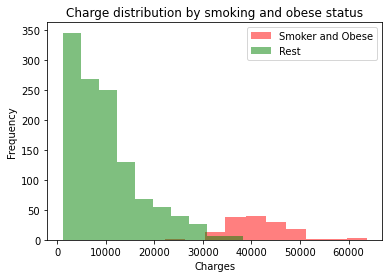

In [45]:
smoke_obese = smoking_boolean & obese_boolean
rest = nonsmoking_boolean | nonobese_boolean
plt.hist(charge_vector[smoke_obese],color ='red', alpha = 0.5, label = 'Smoker and Obese')
plt.hist(charge_vector[rest],color ='green', alpha = 0.5, label = 'Rest')
plt.xlabel('Charges')
plt.ylabel('Frequency')
plt.title('Charge distribution by smoking and obese status')
plt.legend()
plt.show()

Clearly this is a huge factor


In [57]:
print('Increase in charges for those who smoke and are obese: {:.2f} %'.format(charge_vector[smoke_obese].mean()/charge_vector[rest].mean()*100 - 100))
stats.ttest_ind(charge_vector[smoke_obese], charge_vector[rest], alternative = 'greater')

Increase in charges for those who smoke and are obese: 322.67 %


Ttest_indResult(statistic=51.34519192347729, pvalue=1.007667e-318)

# SUMMARY AND CONCLUSIONS

Extra stuff.


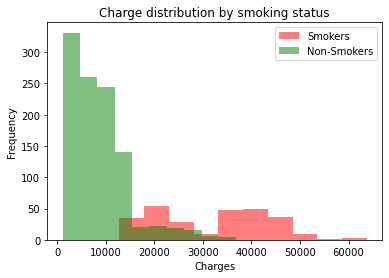

In [13]:
smoker_charges = df[ df['smoker'] == 'yes']['charges'].to_numpy()
nonsmoker_charges = df[ df['smoker'] == 'no']['charges'].to_numpy()
plt.hist(smoker_charges,color ='red', alpha = 0.5, label = 'Smokers')
plt.hist(nonsmoker_charges,color ='green', alpha = 0.5, label = 'Non-Smokers')
plt.xlabel('Charges')
plt.ylabel('Frequency')
plt.title('Charge distribution by smoking status')
plt.legend()
plt.show()

In [ ]:
age_df = df.groupby('age', as_index = False).mean()
a18_25 = age_df[ ( age_df['age'] >= 18 ) & ( age_df['age'] <= 25)].mean(axis = 0).charges
a26_35 = age_df[ ( age_df['age'] >= 26 ) & ( age_df['age'] <= 35)].mean(axis = 0).charges
a36_45 = age_df[ ( age_df['age'] >= 36 ) & ( age_df['age'] <= 45)].mean(axis = 0).charges
a46_55 = age_df[ ( age_df['age'] >= 46 ) & ( age_df['age'] <= 55)].mean(axis = 0).charges
a56p =  age_df[ age_df['age']>= 56].mean(axis = 0).charges
age_split = [a18_25, a26_35,a36_45, a46_55, a56p]
age_split_labels = [r'18-25', r'26-35',r'36-45',r'46-55',r'56+']
plt.bar(age_split_labels, age_split)